# Homework 3: LASSO

## Problem 1: LASSO Path

Modify the code from Homework 2 Problem 2 Part D and Part E to test the false positives produced by LASSO. Use the package *lasso_path* from *sklearn.linear_model* to determine the largest lambda value such that $\{i\}_{i=0}^{9}\subset\text{supp}\hat\beta_\mu$ for all $\mu<\lambda$, and do this for 25 trials for each of the true vectors $\tilde\beta^\ast$, $0.1\cdot \tilde\beta^\ast$, and $10\cdot\tilde\beta^\ast$. Display a histogram for the number of false positives that the LASSO includes when it correctly identifies all the true positives. Discuss your results and how they compare with the Forward-Backward algorithm.

In [2]:
import numpy as np
import numpy.random as rd
import numpy.linalg as la
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from plotly.subplots import make_subplots
from iteration_utilities import deepflatten

In [28]:
def random_design(n,p):
    # Simple function for producing a random design matrix
    return rd.normal(scale=1/np.sqrt(p), size=(n,p))

In [83]:
sigma2 = 0.1
n = 1000
p = 100
beta=np.zeros(100)
for i in range(10):
    beta[i]=1
betas=[beta,beta*0.1,beta*10]
best_lambda=np.zeros((3,25))
best_false_positives=np.zeros((3,25))
ft=[]
for i in range(3):
    beta=betas[i]
    ft_beta=[]
    for j in range(25):
        X = random_design(n, p)
        e = rd.normal(scale=np.sqrt(sigma2), size=(n,))
        y = e+X@beta
        
        alphas, coef_path, _ = lasso_path(X,y,n_alphas=200)
        first_all_detected_index=np.sum((coef_path[0:10,0:200]==0),axis=0).tolist().index(0)
        first_all_detected_lambda=alphas[first_all_detected_index]*2*n
        best_lambda[i,j]=first_all_detected_lambda
        best_false_positives[i,j]=np.sum(coef_path[10:p,first_all_detected_index]!=0)
        
        ft_beta.append(np.sum(coef_path[10:p,first_all_detected_index:200]!=0,axis=0).tolist())
    ft.append(ft_beta)

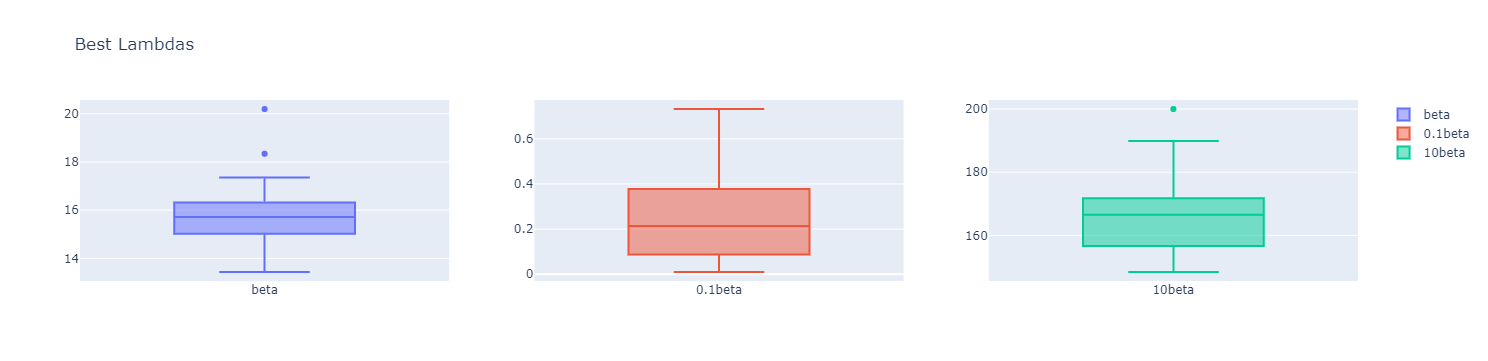

In [84]:
fig = make_subplots(rows=1, cols=3)
trace1= go.Box(
    y=best_lambda[0],
    name='beta'
)
trace2= go.Box(
    y=best_lambda[1],
    name='0.1beta'
)
trace3= go.Box(
    y=best_lambda[2],
    name='10beta'
)

fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 1, col = 2)
fig.append_trace(trace3, row = 1, col = 3)

fig.update_layout(
    title='Best Lambdas')

fig.show()

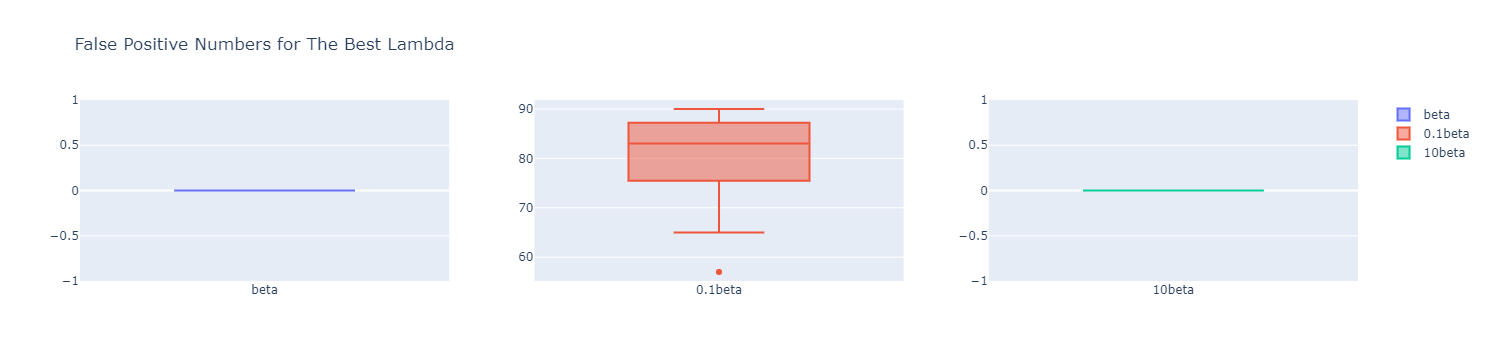

In [86]:
fig = make_subplots(rows=1, cols=3)
trace1= go.Box(
    y=best_false_positives[0],
    name='beta'
)
trace2= go.Box(
    y=best_false_positives[1],
    name='0.1beta'
)
trace3= go.Box(
    y=best_false_positives[2],
    name='10beta'
)

fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 1, col = 2)
fig.append_trace(trace3, row = 1, col = 3)

fig.update_layout(
    title='False Positive Numbers for The Best Lambda')

fig.show()

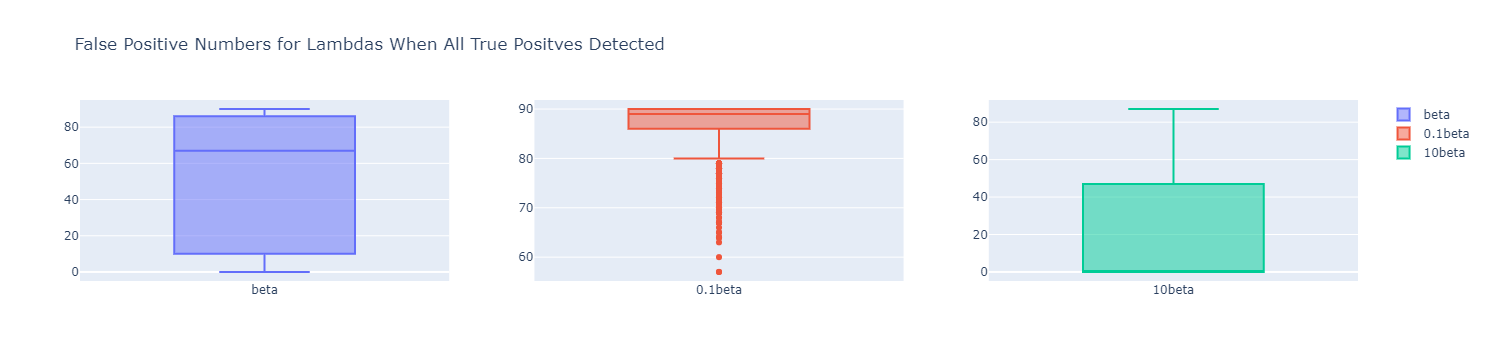

In [92]:
fig = make_subplots(rows=1, cols=3)
trace1= go.Box(
    y=list(deepflatten(ft[0])),
    name='beta'
)
trace2= go.Box(
    y=list(deepflatten(ft[1])),
    name='0.1beta'
)
trace3= go.Box(
    y=list(deepflatten(ft[2])),
    name='10beta'
)

fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 1, col = 2)
fig.append_trace(trace3, row = 1, col = 3)

fig.update_layout(
    title='False Positive Numbers for Lambdas When All True Positves Detected')

fig.show()

### Comment  

**(1)** Best lambdas are in different ranges when betas are in different scales.  
**(2)** When betas are large enough, with best_lambda the model could detect all the true positives with 0 positives. When betas are small, true positives are detected along with false positives.  
**(3)** The main difference of LASSO between penalized terms of AIC or BIC in hw2 is that, when betas are small, LASSO detected many more true positves as well as false positives (with best lambda) than AIC & BIC computed by the Forward-Backward algorithm.  
**(4)** While least square problems with penalized terms of AIC, BIC can be computed by the Forward-Backward algorithm, LASSO cannot be computed by it. That's because the penalized terms of AIC,BIC can be computed directly from the size of support while the penalized terms of LASSO cannot.

## Problem 2: LASSO for Riboflavin

Implement a coordinate descent procedure to perform LASSO for the Riboflavin dataset with $\lambda = 10^k\log(p)$ for $k=-2,-1,0,1,2$. For each of these $\lambda$ values, use a bootstrapping procedure to perform the following experiment 25 times: randomly choose 50 samples for training, fit LASSO with parameter $\lambda$ using coordinate descent, and then compute the predictive error on the 21 samples retained for testing. Create box and whisker plots for the 25 predictive errors across the 5 different $\lambda$ values, and indicate which $\lambda$ appears to have the best predictive behavior.

In [229]:
def soft_thres(x,lamb):
    if(x>lamb):
        return(x-lamb)
    if(x<-lamb):
        return(x+lamb)
    return 0
def coord_des_lasso(y, X, beta0, lamb, error, maxstep):
    n=X.shape[0]
    p=X.shape[1]
    beta = beta0
    r_prev = 0.5*la.norm(y-X@beta)**2+lamb*la.norm(beta,ord=1)
    step = 0
    while(step < maxstep):
        #print("#######")
        #print("Step"+str(step))
        for i in range(p):
            beta_temp=np.array(beta)
            beta_temp[i]=0
            y_temp = y-X@beta_temp
            beta[i]=soft_thres(np.dot(y_temp,X[:,i]),lamb)/(la.norm(X[:,i])**2)
        r_cur = 0.5*la.norm(y-X@beta)**2+lamb*la.norm(beta,ord=1)
        if(np.abs(r_cur-r_prev)<error or step==maxstep-1):
            err_final=np.abs(r_cur-r_prev)
            break
        else:
            r_prev=r_cur
            step=step+1
    return beta, step, err_final

In [184]:
df_rx=pd.read_csv('riboflavin/riboflavinx.csv')
df_ry=pd.read_csv('riboflavin/riboflaviny.csv')
rx=np.array(df_rx.iloc[:,1:4089])
ry=np.array(df_ry.iloc[:,1])

In [244]:
prederr_record=np.zeros((5,25))
ind = [-2,-1,0,1,2]
for i in range(5):
    print('#####')
    print("lambda_"+str(i+1))
    for j in range(25):
        print("  step_"+str(j+1))
        train_index=rd.choice(np.arange(71),50,replace=False)
        test_index=np.setdiff1d(np.arange(71),train_index)

        train_X = rx[train_index,:]
        train_y = ry[train_index]
        test_X = rx[test_index,:]
        test_y = ry[test_index]

        beta0=np.zeros(train_X.shape[1])
        lamb = np.log(train_X.shape[1])*(10**ind[i])
        beta, step, err = coord_des_lasso(train_y,train_X,beta0,lamb,0.1,100)

        pred_err = 0.5*la.norm(test_y-test_X@beta)**2
        prederr_record[i,j]=pred_err

#####
lambda_1
  step_1
  step_2
  step_3
  step_4
  step_5
  step_6
  step_7
  step_8
  step_9
  step_10
  step_11
  step_12
  step_13
  step_14
  step_15
  step_16
  step_17
  step_18
  step_19
  step_20
  step_21
  step_22
  step_23
  step_24
  step_25
#####
lambda_2
  step_1
  step_2
  step_3
  step_4
  step_5
  step_6
  step_7
  step_8
  step_9
  step_10
  step_11
  step_12
  step_13
  step_14
  step_15
  step_16
  step_17
  step_18
  step_19
  step_20
  step_21
  step_22
  step_23
  step_24
  step_25
#####
lambda_3
  step_1
  step_2
  step_3
  step_4
  step_5
  step_6
  step_7
  step_8
  step_9
  step_10
  step_11
  step_12
  step_13
  step_14
  step_15
  step_16
  step_17
  step_18
  step_19
  step_20
  step_21
  step_22
  step_23
  step_24
  step_25
#####
lambda_4
  step_1
  step_2
  step_3
  step_4
  step_5
  step_6
  step_7
  step_8
  step_9
  step_10
  step_11
  step_12
  step_13
  step_14
  step_15
  step_16
  step_17
  step_18
  step_19
  step_20
  step_21
  step_22
  step

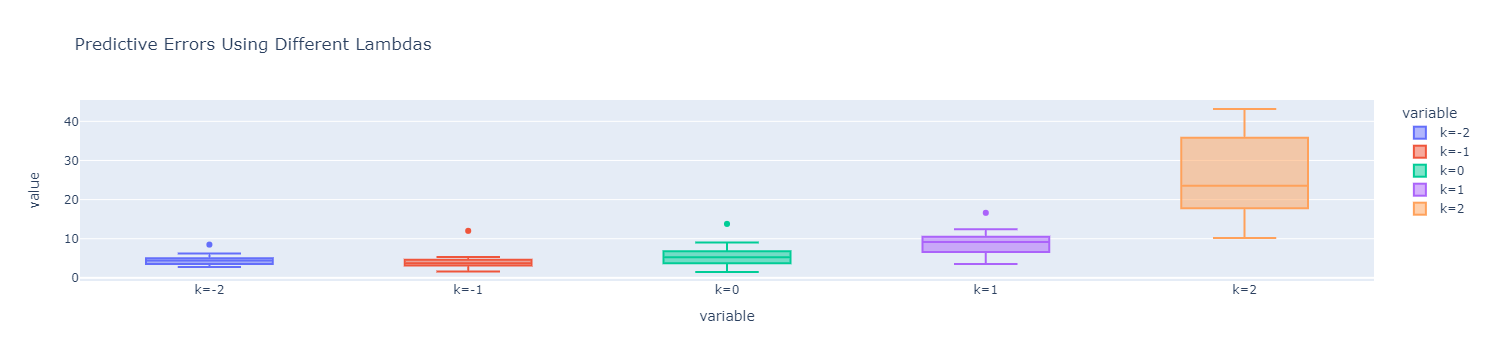

In [251]:
df_temp = pd.DataFrame(prederr_record.T, columns=['k=-2','k=-1','k=0','k=1','k=2'])
df_tidy = pd.melt(df_temp)

px.box(df_tidy, x='variable', y='value', color='variable',title='Predictive Errors Using Different Lambdas')

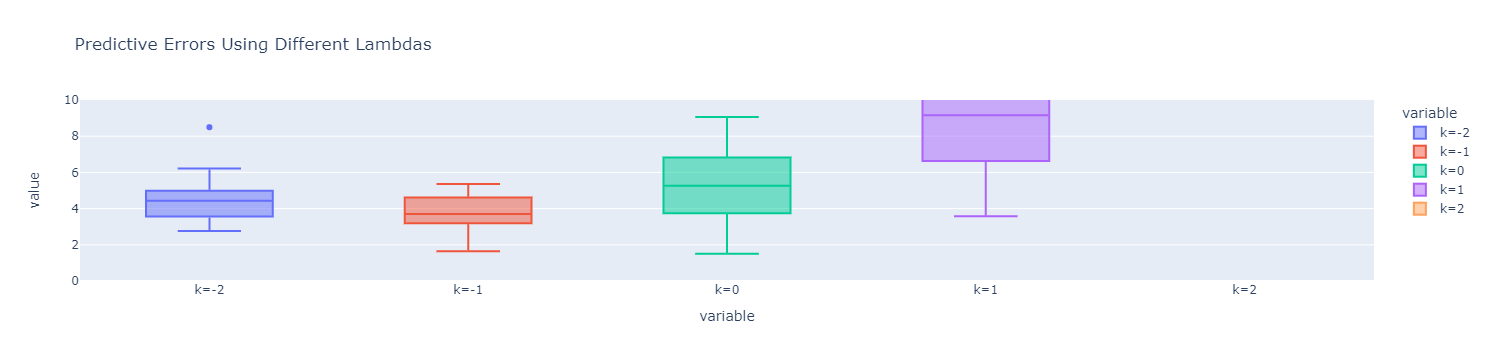

In [250]:
px.box(df_tidy, x='variable', y='value', color='variable',title='Predictive Errors Using Different Lambdas',range_y=[0,10])

### Comment
As we can see in the boxplot, when $k=-1,\ \lambda=0.83$, we have the best predictive behavior.

## Problem 3: Penalized Logistic Regression for Prostate Dataset

Consider the following example involving this standard prostate cancer dataset:

#### Singh, Dinesh, Phillip G. Febbo, Kenneth Ross, Donald G. Jackson, Judith Manola, Christine Ladd, Pablo Tamayo et al. "Gene expression correlates of clinical prostate cancer behavior." Cancer cell 1, no. 2 (2002): 203-209.

This particular example provides a very sparse logistic regression parameter $\beta$ that performs perfect prediction on the test dataset. 

Modify this code to perform 25 random runs to induce a "bootstrap" sample of $\beta$ and the training error. Determine the indices $i$ such that $\vert\beta_i\vert>10^{-3}$ for at least one of the bootstrap runs, and create box and whisker plots for the coefficients obtained under these indices. Discuss your results.

In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

def eta(a, lam):
    '''
    Soft threshold function
    :param a: parameter to threshold
    :param lam: shrinkage parameter
    :return: soft thresholded value
    '''
    return np.sign(a) * max(0, np.abs(a)-lam)

def logit(x):
    return 1/(1+np.exp(-x))

def lrl1cdmm(y, X, lam=1.0, its=1000, initial=None, verbose=False, verbose_graphs=False):
    '''
    l1 penalized logistic regression solver using majorization-minimization coordinate descent
    :param y: vector of binary labels (0 and 1's)
    :param X: design matrix (not assumed to have a constant column)
    :param lam: l1 penalty term -- higher means solution is sparser
    :param its: number of "outer" iterations of coordinate descent
    :param initial: default None triggers b=0, otherwise the initial vector for the iteration
    :param verbose: toggle convergence assessments for each iteration
    :param verbose_graphs: toggle graphs to illustrate majorization at each step
    :return: b ~ arg min N^{-1}sum_i log(1+e^{(-1)^y_i x_i^Tb) + lam*||b||_1
    '''

    # Observe that
    # x_i^T = x_i^T(b-b_j e_j)^T + x_i^T(b_j e_j) = (x_i^Tb - b_jx_{i,j}) + b_j x_{i,j}
    # d_{b_j}[ log(1+e^{(-1)^{y_i}(c + b_j x_{i,j})}) ] = (-1)^{y_i}x_{i,j}/(1+e^{-(-1)^{y_i}(c + b_j x_{i,j})})
    # d_{b_j}^2[ log(1+e^{(-1)^{y_i}(c + b_j x_{i,j})}) ] = x_{i,j}^2 * logit(-c-b_jx_{i,j}) * logit(c+b_jx_{i,j})
    # so d_{b_j}^2[ log(1+e^{(-1)^{y_i}(c + b_j x_{i,j})}) ] <= x_{i,j}^2/4

    # This suggests the following coordinate majorization:
    # log(1+e^{(-1)^{y_i}(c + bj(t+1) x_{i,j})}) <= log(1+e^{(-1)^{y_i}(c + bj(t) x_{i,j})})
    #           + (-1)^{y_i}x_{i,j}/(1+e^{-(-1)^{y_i}(c + bj(t) x_{i,j})})*(bj(t+1) - bj(t))
    #           + x_{i,j}^2 * (bj(t+1)-bj(t))^2 / 8

    # This majorization results in a quadratic of the form p(bj(t+1) - bj(t))^2 + q(bj(t+1)-bj(t)) + r, which becomes
    # p bj(t+1)^2 - 2*p*bj(t) bj(t+1) + p bj(t)^2 + q*bj(t+1) - q*bj(t) + r
    #   = p*bj(t+1)^2 + (q-2*p*bj(t))bj(t+1) + c
    #   = p*(bj(t+1) - (bj(t) - (q/2p))^2 + C
    # This is after completing the square, of course
    # letting a = bj(t) - q/2p, we consider optimizing
    # p(bj - a)^2 + lam |bj| --> (bj-a)^2/2 + (lam/2p)|bj|
    # Therefore, we are soft thresholding a using the parameter (lam/2p).

    # Note that p = sum_i x_{i,j}^2 / 8*N, q = sum_i (-1)^{yi}x_{i,j}/(1+e^{-(-1)^{yi}b(t)^T xi)}) / N

    N = X.shape[0] # Number of examples
    num_pred = X.shape[1]
    p = np.sum(X**2, axis=0) / (8*N) # precompute the p's
    V = np.einsum('ij,i->ij', X, np.reshape((-1)**y, (N,)))

    if initial is None:
        b = np.zeros((num_pred, 1))
    else:
        b = initial

    NLL = lambda q0: np.sum(np.log(1+np.exp(V@q0)))/N
    regNLL = lambda q0: NLL(q0) + lam*np.sum(np.abs(q0))
    identity = np.eye(num_pred)
    regnnl_coord = lambda q, q0, k: regNLL(q0 + (q-q0[k,0])*np.reshape(identity[:,k], (num_pred,1)))

    reg_term = lambda q, q0, k: lam*np.sum(np.abs(q0 + (q-q0[k,0])*np.reshape(identity[:,k], (num_pred,1))))
    mm_fcn = lambda q, q0, k: NLL(q0) + (np.dot(V[:,j], logit(V@q0))[0]*(q-q0[k,0])/N) + p[k]*(q-q0[k,0])**2
    mm_coord = lambda q, q0, k: mm_fcn(q,q0,k) + reg_term(q,q0,k)

    if verbose:
        b_old = np.copy(b)

    for i in range(its):
        if verbose:
            print('Iter: %d, NLL: %4.2f, res: %f' % (i, regNLL(b),np.sum((b-b_old)**2)))
            b_old = np.copy(b)
        for j in range(num_pred):
            #if verbose:
            #print('  Inner Iter: %d, NLL: %4.2f' % (j, regNLL(b)))
            q = np.dot(V[:,j], logit(V@b))[0] / N

            b_new = eta(b[j,0]-q/(2*p[j]), lam/(2*p[j]))

            if verbose_graphs:
                regnnl_coordj = lambda bj: regnnl_coord(bj, b, j)
                mm_coordj = lambda bj: mm_coord(bj, b, j)
                print((regnnl_coordj(b[j,0]), mm_coordj(b[j,0])))

                res = 64
                t = b[j] + (b_new-b[j])*np.linspace(-1, 1, res)
                nll = np.zeros(res)
                mm = np.zeros(res)
                for l in range(res):
                    nll[l] = regnnl_coordj(t[l])
                    mm[l] = mm_coordj(t[l])

                # Plot for regularized negative log likelihood along coordinate (blue)
                plt.plot(t, nll)
                # Plot for coordinate majorization function (orange)
                plt.plot(t, mm)
                # the orange curve should dominate the blue curve
                plt.show()

            b[j,0] =  eta(b[j,0]-q/(2*p[j]), lam/(2*p[j]))

    return b

rd.seed(37)

df = pd.read_csv("./prostate/prostate.csv", nrows=102)

y = df['y'].values
X = df[df.columns[:6033]].values

n_train = 70
n_test = 32

shuffle_index = rd.permutation(102)
shuffle_index.tolist()

X_train = X[shuffle_index[:n_train], :]
X_test = X[shuffle_index[n_train:], :]

y_train = y[shuffle_index[:n_train]]
y_test = y[shuffle_index[n_train:]]

its = 200 #Iteration maximum

b_approx = lrl1cdmm(y_train, X_train, lam=1e-1, its=its, verbose=False)
y_pred = np.round(logit(X_test @ b_approx))

# Orange stars on green dots indicate successful prediction
plt.plot(y_test,'o')
plt.plot(y_pred,'*')
plt.show()

lrl2 = LogisticRegression(penalty='l2', solver='saga', max_iter=its, random_state=37).fit(X_train, y_train)
print('Score for 12 Regularized Logistic Regression:')
lrl2.score(X_test, y_test)

KeyboardInterrupt: 

In [2]:
import pandas as pd
df = pd.read_csv("./prostate/prostate.csv", nrows=102)

y = df['y'].values
X = df[df.columns[:6033]].values

In [5]:
X.shape

(102, 6033)

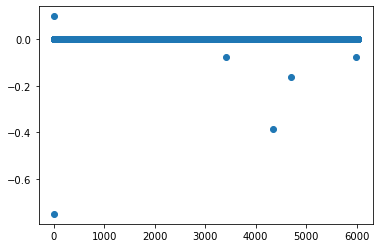

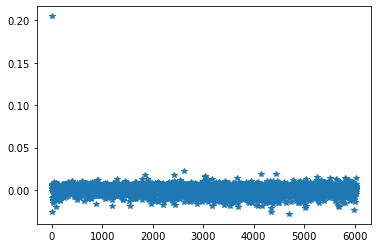

In [4]:
plt.plot(b_approx,'o')
plt.show()

plt.plot(lrl2.coef_.T, '*')
plt.show()

### Transformed Codes

In [15]:
pX = pd.read_csv('prostate/prostate.csv')
pY = pX.iloc[:,-1]
pX = pX.iloc[:,1:6034]

In [ ]:
train_index = rd.choice(np.arange(101),80,replace=False)
test_index = np.setdiff1d(np.arange(101),train_index)
pX_train = pX.iloc[train_index,:]
pY_train = pY[train_index]

In [39]:
b_l1_rec=[]
b_l2_rec=[]
for i in range(25):
    print('Step'+str(i+1))
    train_index = rd.choice(np.arange(101),80,replace=False)
    test_index = np.setdiff1d(np.arange(101),train_index)
    pX_train = pX.iloc[train_index,:]
    pY_train = pY[train_index]
    
    print('  l1')
    b1 = lrl1cdmm(pY_train, pX_train, lam=1e-1, its=its, verbose=False)
    b_l1_rec.append(b1)
    
    print('  l2')
    model=LogisticRegression(penalty='l2', solver='saga', max_iter=1000, random_state=37).fit(pX_train, pY_train)
    b_l2_rec.append(model.coef_)
    

Step1
  l1
  l2
Step2
  l1
  l2
Step3
  l1
  l2
Step4
  l1
  l2
Step5
  l1
  l2
Step6
  l1
  l2
Step7
  l1
  l2
Step8
  l1
  l2
Step9
  l1
  l2
Step10
  l1
  l2
Step11
  l1
  l2
Step12
  l1
  l2
Step13
  l1
  l2
Step14
  l1
  l2
Step15
  l1
  l2
Step16
  l1
  l2
Step17
  l1
  l2
Step18
  l1
  l2
Step19
  l1
  l2
Step20
  l1
  l2
Step21
  l1
  l2
Step22
  l1
  l2
Step23
  l1
  l2
Step24
  l1
  l2
Step25
  l1
  l2


In [64]:
b1 = np.reshape(np.array(b_l1_rec),(25,6033))
b2 = np.reshape(np.array(b_l2_rec),(25,6033))

In [101]:
trlist1 = np.arange(6033)[np.sum(b1>1e-3,axis=0)!=0]
trlist2 = np.arange(6033)[np.sum(b2>0.8e-1,axis=0)!=0]

In [113]:
df1_plot = pd.DataFrame(b1[:,trlist1],columns=[str(ind) for ind in (trlist1+1).tolist()])
df2_plot = pd.DataFrame(b2[:,trlist2],columns=[str(ind) for ind in (trlist2+1).tolist()])

In [119]:
df1_tidy = pd.melt(df1_plot)
df2_tidy = pd.melt(df2_plot)

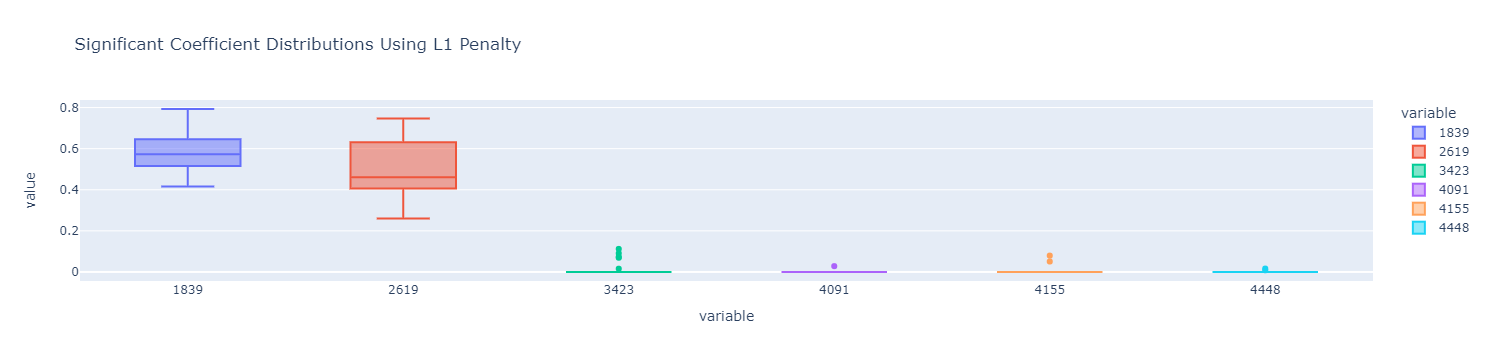

In [121]:
px.box(df1_tidy,x='variable',y='value',color ='variable',title='Significant Coefficient Distributions Using L1 Penalty')

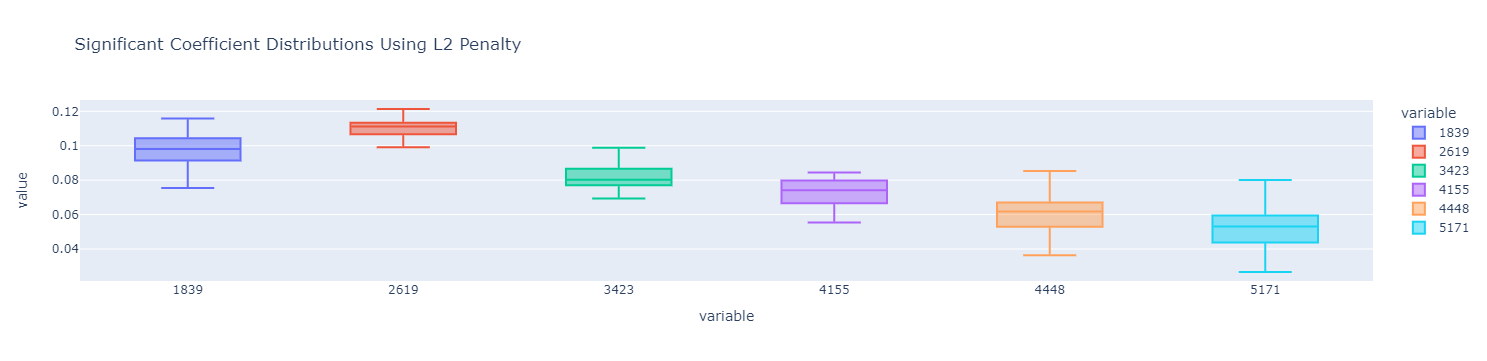

In [122]:
px.box(df2_tidy,x='variable',y='value',color ='variable',title='Significant Coefficient Distributions Using L2 Penalty')

### Comment
In the l1-norm part, we can extract all the coefficients that are greater than $10^{-3}$ in at least one run and finally found there are about 6 such coefficients. In the l2-norm part, we will achieve almost 2/3 of the predictors if we still keep the restriction as $10^{-3}$. When we change it into 0.08, we can have almost the same amount of predictors as l1-norm part.  

From the two boxplots, we can see l1 penalty and l2 penalty both detect the significant predictors of the 1839th entry and 2619th entry. And the difference between two methods is that, other variables are not so significant in l1-norm penalty, while in l2-penalty the significant variables are in similar scales.

## Problem 4: Total Variation Regularization for Finance Dataset

Modify the following example code to fit a piecewise constant function to the data from Problem 4 of HW2. How does this fit compare with the wavelet fit?

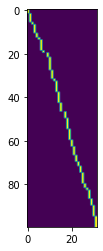

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
178.85780082260834


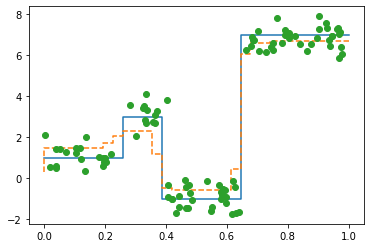

In [237]:
def eta(a, lam):
    '''
    Soft threshold function
    :param a: parameter to threshold
    :param lam: shrinkage parameter
    :return: soft thresholded value
    '''
    return np.sign(a) * max(0, np.abs(a)-lam)


def tvcd(y, X, lam=1.0, iter=100, initial=None, verbose=False):
    '''
    Coordinate descent method for minimizing total variation
    :param y: N-dimensional response vector
    :param X: N by p design matrix
    :param lam: total variation regularization parameter
    :param iter: total number of full coordinate descent steps
    :param initial: default initialize to 0, otherwise tuple (v, c) with v deriv and c constant
    :param verbose: toggle for outputs
    :return: beta vector
    '''

    # min ||y - Xb||^2/2N + lam*||Db||_1
    # min ||y - X(Av+c1)||^2/2N + lam*||v||_1
    # min ||y - XAv - cXbar||^2/2N + lam*||v||_1
    # A is the partial summation matrix

    N = X.shape[0]
    p = X.shape[1]
    XA = np.fliplr(np.cumsum(np.fliplr(X), axis=1))
    Xbar = np.copy(XA[:,0])
    XA = XA[:,1:]

    f = lambda v, c: np.sum((y-XA@v-c*Xbar)**2) + lam*np.sum(np.abs(v))

    # Consider updating ||q - XA_j*vj||^2/2N + lam*|vj| + C
    # This is ||XA_j||^2vj^2 - 2q.T XAj * vj + ||q||^2 + lam*|vj| + C
    # ||XA_j||^2(vj-q.T XAj/||XAj||)^2 + lam*|vj| + C'
    # threshold q.T XAj by lam/2r with r = ||XA_j||^2/2N

    # Consider updating ||q - c Xbar||^2... ||Xbar||^2 c = q.T Xbar, so c = q.T Xbar/||Xbar||^2

    # Precompute necessary quantities
    r = np.sum(XA**2, axis=0)
    XAr = np.einsum('ij,j->ij', XA, 1/r)
    xbar2 = np.sum(Xbar**2)

    if initial is None:
        v = np.zeros(p-1)
        c = 0
    else:
        v = initial[0]
        c = initial[1]

    for i in range(iter):
        print('Step '+str(i))
        if verbose:
            print('Iter: %d, Val: %f' % (i,f(v,c)))
        for j in range(p-1):
            if verbose:
                print('  Inside Iter: %d, Val: %f' % (j,f(v,c)))
            q = y-XA@v+v[j]*XA[:,j]-c*Xbar
            v[j] = eta(np.dot(q, XAr[:,j]), lam/(2*r[j]))
            c = np.dot(Xbar, y-XA@v)/xbar2
    print(f(v,c))
    return c + np.concatenate(([0],np.cumsum(v)))

np.random.seed(37)

N = 100 # Number of samples
p = 32 # this is the resolution of the fit
sigma2 = 0.25
lamb = N*1e-1

# The true sparse discrete differences are in v, c is the constant component
v = np.zeros(p-1)
v[8] = 2
v[12] = -4
v[20] = 8
c = 1

# Form b by "integrating" the discrete difference using cumulative sums
b = c + np.concatenate(([0],np.cumsum(v)))

# Randomly sample time points
t = np.sort(np.random.rand(N)) 

# Form the design matrix by determining the beta index
X = np.zeros((N,p))
for i in range(N):
    tau = p*t[i]
    k = int(np.floor(tau))
    X[i, k] = 1.0

plt.imshow(X)
plt.show()

# Add random noise
y = X @ b + np.sqrt(sigma2)*np.random.randn(N)

# Setup the nodes
nodes = np.linspace(0,1,p)

# Perform modified coordinate descent for TV
b_approx = tvcd(y, X, iter=20, lam=lamb)

plt.step(nodes, b)
plt.step(nodes, b_approx, '--')
plt.plot(t, y, 'o')
plt.show()


### Transformed Codes

In [238]:
cols = ['Date', 'Time', 'Bid', 'Price', 'Ask', 'Size']
df = pd.read_csv("./finance/IVE_tickbidask.txt", nrows=2048, names=cols)

In [239]:
pixel = 80
df['t'] = df.apply(lambda row : pd.to_datetime(row['Date'] + ' ' + row['Time']).value/(10**9), axis = 1) 
df['t'] = df['t'] - np.min(df['t'])
df['t'] = df['t']/pixel

In [242]:
N = df.shape[0]
p = int(np.max(df['t']))
X=np.zeros((N,p+1))
for i in range(N):
    tau = int(df.loc[i,'t'])
    X[i,tau] = 1
y = np.array(df['Price'])

In [255]:
b = tvcd(y,X,iter=100,initial=[np.zeros(p),y[0]],lam=N*1e-3)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
3.936099880278514


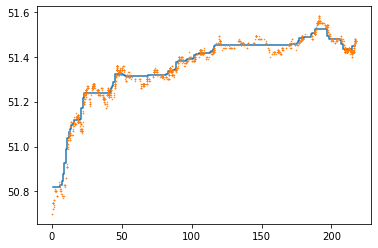

In [256]:
plt.step(np.arange(1,p+1),b[1:p+1])
plt.plot(df['t'],df['Price'],'o',markersize=0.5)
plt.show()

### Comment
We can see after choosing a good initial $c$ and a suitable $\lambda$, we can achieve a good piecewise constant approximation to the original points.  

One difference is that we can have more control over the model. While in wavelet we can only change the resolution as $2^{n}$ there, here we can change $\lambda$ to have more or less details for the model (also we can select a good initial value to reduce the steps to convergence). 

In addition, the result of wavelet model there is rough even we choose a good resolution. Here with a good $\lambda$ and a suitable initial value, we can achieve a model which reveals more details and close to the original points.

## Problem 5: Choose your own adventure

Using your own dataset (the high-dimensional dataset from Homework 1), use LASSO, $\ell_1$-penalized logistic regression, total variation regularization, or sparse dictionary learning and discuss your results. 

In [257]:
df1=pd.read_csv('data.csv')
df2=pd.read_csv('labels.csv')
df1=df1.iloc[:,1:20532]
df2=df2.iloc[:,1]

'data.csv' collects the gene expressions. 'labels.csv' represents the kinds of cancer.  
To carry out a logistic regression, we only consider whether the label is 'LUAD' or not, making it a binary-classification problem.

In [258]:
labels=np.zeros(801)
labels[df2=='LUAD']=1

In [259]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, labels, test_size=0.2, random_state=42)

In [260]:
from sklearn.svm import l1_min_c
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

cs = l1_min_c(X_train, y_train, loss="log") * np.logspace(0, 7, 16)

clf = linear_model.LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)

coefs_ = []
error=[]
for c in cs:
    clf.set_params(C=c)
    clf.fit(X_train, y_train)
    coefs_.append(clf.coef_.ravel().copy())
    error.append(np.mean(clf.predict(X_test)-y_test)**2)

In [261]:
error

[0.032444735928397826,
 0.032444735928397826,
 0.00015431503414220128,
 3.857875853555032e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [262]:
norms=[]
for array in coefs_:
    norms.append(np.sum(array!=0))
norms

[0, 1, 1, 1, 6, 11, 13, 21, 25, 26, 37, 38, 48, 606, 621, 937]

In [263]:
from sklearn.linear_model import LogisticRegression
temp_model = LogisticRegression(fit_intercept=False,solver='liblinear').fit(X_train, y_train) 
np.mean((temp_model.predict(X_test)-y_test)**2)

0.0

In [264]:
np.sum(temp_model.coef_.ravel()!=0)

20258

### Comment
As we can see, the penalized term not only maintained the accuracy but also reduced the size of the support.